In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
from statsmodels.api import OLS, add_constant
import pandas_datareader.data as web
from pandas_datareader.famafrench import get_available_datasets
import yfinance as yf
import datetime as dt

from linearmodels.asset_pricing import LinearFactorModel

Blog post on Python application of factor model \
https://psystat.tistory.com/147#footnote_link_147_5

Blog post explaining how Fama-Macbeth 2 Step Regression method is conducted \
https://www.simtrade.fr/blog_simtrade/fama-macbeth-two-step-regression-method/

Stackexchange Q&A on the factor model methodologies \
https://quant.stackexchange.com/questions/46746/rationale-of-fama-macbeth-procedure?rq=1

In [2]:
# get list of FF dataset names
datasets = get_available_datasets()

# search for relevant dataset
search_keyword_1 = 'Research'
search_keyword_2 = '5_Factor'
search_result = [dataset for dataset in datasets if (search_keyword_1 in dataset) and (search_keyword_2 in dataset)]
print(search_result)

['F-F_Research_Data_5_Factors_2x3', 'F-F_Research_Data_5_Factors_2x3_daily']


### Download 5 FF Factors
Factors data are in "returns" format; they are simply the difference between average returns of two bipolar groups given a certain factor. \
e.g. Small Minus Big = Small Cap Group's average returns - Large Cap Group's average returns, where factor is SIZE.

In [3]:
# 2020~2023 monthly returns
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
end = dt.datetime.now()
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2020-04', end=end)[0]
end_date = ff_factor_data.iloc[-1].name
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 43 entries, 2020-04 to 2023-10
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  43 non-null     float64
 1   SMB     43 non-null     float64
 2   HML     43 non-null     float64
 3   RMW     43 non-null     float64
 4   CMA     43 non-null     float64
 5   RF      43 non-null     float64
dtypes: float64(6)
memory usage: 2.4 KB


In [4]:
tickers = ['AAPL','O','NVDA','MSFT','DIS','GOOGL','PYPL']
PF_price = yf.download(tickers, 
                       start='2020-03-01',
                       end=end_date.to_timestamp() + dt.timedelta(days=31),
                       interval='1mo', progress=False)['Adj Close']
PF_price.index = PF_price.index.to_period('M')

# convert returns into excess returns over risk-free rate used by FF Market Factor
PF_returns = PF_price.pct_change(1).dropna().loc[:end_date] * 100
PF_returns = PF_returns.sub(ff_factor_data.RF, axis=0)
PF_returns.info()

# drop risk-free rate column in FF Factors data
ff_factor_data = ff_factor_data.drop('RF', axis=1)
ff_factor_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 43 entries, 2020-04 to 2023-10
Freq: M
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    43 non-null     float64
 1   DIS     43 non-null     float64
 2   GOOGL   43 non-null     float64
 3   MSFT    43 non-null     float64
 4   NVDA    43 non-null     float64
 5   O       43 non-null     float64
 6   PYPL    43 non-null     float64
dtypes: float64(7)
memory usage: 2.7 KB
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 43 entries, 2020-04 to 2023-10
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  43 non-null     float64
 1   SMB     43 non-null     float64
 2   HML     43 non-null     float64
 3   RMW     43 non-null     float64
 4   CMA     43 non-null     float64
dtypes: float64(5)
memory usage: 2.0 KB


### Step 1: Factor Exposures: time-series regression of returns ~ factors (in returns)
Just like running a simple CAPM regression for a single stock: [E(R_t) - Rf] = a_t + B_i[Rm_t - Rf],
run multivariate Time Series Regression on other FF factors in returns format.
- Y = The return of asset i observed over the time period 1~T.
- X = The FF risk factors influencing the asset i's returns.
- Resulting Beta = factor sensitivity/factor-loadings/factor exposures of asset i's returns ro FF risk factors over the regression period.
    - e.g. CAPM Market Beta = how much % asset i's returns change when equity market excess returns change 1%
    - Likewise, other factors indicate how sensitive asset i's returns are to change in returns of certain factor exposures; SMB: if asset shares similar features with small caps, the returns will have positive sensitivity with the excess returns of Small Cap over Large Cap factor
    - It must also be noted that these factor sensitivity only holds for the regression period. Given that asset features can change over time and so does factor exposures, e.g. small cap growing into large cap stocks, how can this change be handled? --> maybe rolling regression over windows of different time period will do.

In [5]:
betas = []
for asset in PF_returns:
    # Time series regression of industry portfolio returns on FF5 factor returns --> get Factor Exposures (Betas)
    step1 = OLS(endog=PF_returns.loc[ff_factor_data.index, asset], 
                exog=add_constant(ff_factor_data)
                ).fit()
    betas.append(step1.params.drop('const'))

    
betas = pd.DataFrame(betas, 
                     columns=ff_factor_data.columns, 
                     index=PF_returns.columns)
betas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7 entries, AAPL to PYPL
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  7 non-null      float64
 1   SMB     7 non-null      float64
 2   HML     7 non-null      float64
 3   RMW     7 non-null      float64
 4   CMA     7 non-null      float64
dtypes: float64(5)
memory usage: 636.0+ bytes


In [6]:
# Exposure of Each stocks to 5 FF Factors
betas

,Mkt-RF,SMB,HML,RMW,CMA
AAPL,1.269898,-0.256815,-0.836984,0.156780,0.605706
DIS,1.409615,0.310576,0.463026,-0.716536,-0.413308
GOOGL,1.116498,-0.556212,0.318994,-0.294321,-0.973217
MSFT,0.907399,-0.506253,-0.508811,0.102958,0.136773
NVDA,1.742280,-0.624249,-0.673048,0.081294,-0.849354
O,0.751741,0.137095,-0.090288,0.538243,0.207432
PYPL,1.769445,-0.032915,0.049365,-1.303444,-0.334144


### Step 2: Risk Premia: cross-sectional regression of periodic returns ~ factor exposures (sensitivities)
For each period t from 1 to T, we estimate cross-sectional linear regression model:
- Y = N asset i's returns in a given period, cross-sectional returns of the portfolio assets in a given time (time is fixed)
- X = N x 5 FF factors for each asset i's calculated from the first period (Factor exposures are assumed to be constant over the regression period 1~T, as they are not re-estimated over different time periods)
- Resulting Beta: 
    - Also named 'Lambda'; lambdas estimates for the risk-premium (in 'returns') of your risk-factors.
    - Economic interpretation is how much the expected stock return would rise, if this stocks risk-factor (Factor Exposure, Beta) increases one unit.
    - Lambdas are estimated for each time period, so the resulting Lambdas are in Time series from 1~T by 5 FF Facotors, for the portfolio as a whole.
    - To calculate the lambda for portfolio in the regression time period, lambdas are averaged across the time.

In [7]:
# cross-section of asset returns in a given time period
PF_returns.head(1)

,AAPL,DIS,GOOGL,MSFT,NVDA,O,PYPL
Date,,,,,,,
2020-04,15.537376,11.956524,15.899994,13.632598,10.880121,10.633609,28.47295


In [8]:
# factor exposures assumed constant during the regression period to calculate lambdas (Risk premia)
betas.T

,AAPL,DIS,GOOGL,MSFT,NVDA,O,PYPL
Mkt-RF,1.269898,1.409615,1.116498,0.907399,1.742280,0.751741,1.769445
SMB,-0.256815,0.310576,-0.556212,-0.506253,-0.624249,0.137095,-0.032915
HML,-0.836984,0.463026,0.318994,-0.508811,-0.673048,-0.090288,0.049365
RMW,0.156780,-0.716536,-0.294321,0.102958,0.081294,0.538243,-1.303444
CMA,0.605706,-0.413308,-0.973217,0.136773,-0.849354,0.207432,-0.334144


In [9]:
lambdas = []

for period in PF_returns.index:
    # for every period, run cross-sectional regression of portfolio (assets) returns on Factors Exposures of each assets
    step2 = OLS(endog=PF_returns.loc[period, betas.index],
                exog=betas # result from adding constant [add_constant(betas)] in this regression is equivalent to , risk_free=True
                ).fit()
    lambdas.append(step2.params)
    
lambdas = pd.DataFrame(lambdas, 
                       index=PF_returns.index,
                       columns=betas.columns.tolist())

lambdas.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 43 entries, 2020-04 to 2023-10
Freq: M
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  43 non-null     float64
 1   SMB     43 non-null     float64
 2   HML     43 non-null     float64
 3   RMW     43 non-null     float64
 4   CMA     43 non-null     float64
dtypes: float64(5)
memory usage: 3.1 KB


In [10]:
lambdas.tail()

,Mkt-RF,SMB,HML,RMW,CMA
Date,,,,,
2023-06,1.024480,9.048658,-16.586156,-3.589639,-5.203084
2023-07,1.337854,-2.020613,-3.027796,-3.620618,-6.014358
2023-08,-6.026059,-0.917881,-6.894957,5.286243,-11.893358
2023-09,-6.743944,-5.033470,2.895334,-5.672949,1.664419
2023-10,-1.702027,-7.831505,5.081973,1.761264,6.949640


In [11]:
# Portfolio's risk premium on each factors to form expected returns
lambdas.mean()

Mkt-RF    0.652401
SMB      -0.399504
HML      -2.860353
RMW       1.441230
CMA      -2.321468
dtype: float64

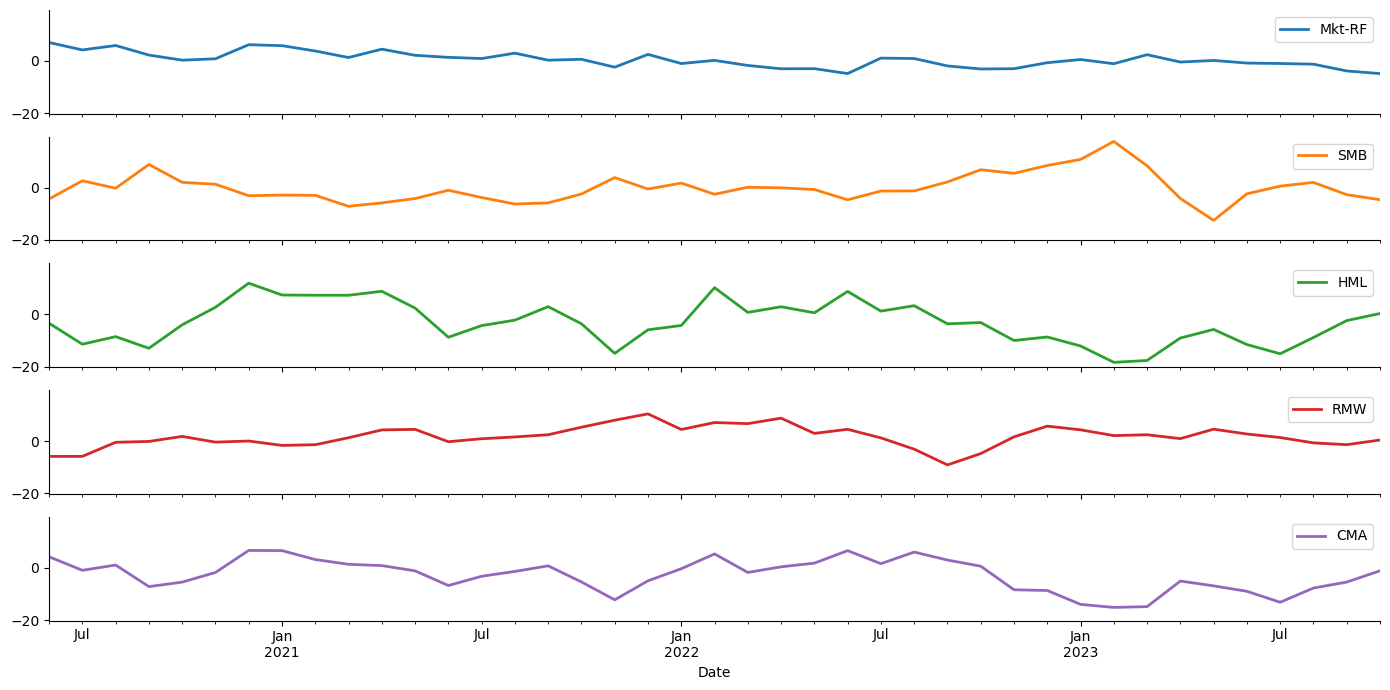

In [12]:
window = 3  # months
lambdas.rolling(window).mean().dropna().plot(lw=2, figsize=(14, 7), subplots=True, sharey=True)
sns.despine()
plt.tight_layout()

### How much does the factor exposure change over time?
By estimating first step regression on rolling window of the regression data, we can see how much the factor exposure change over time. This can give us a sense of reliability of whether assuming factor exposureas constant during our regression period is valid assumption for the second step regression.

In [13]:
def FF_betas(PF_returns, ff_factor_data):
    betas = []
    for asset in PF_returns:
        # Time series regression of industry portfolio returns on FF5 factor returns --> get Factor Exposures (Betas)
        step1 = OLS(endog=PF_returns.loc[ff_factor_data.index, asset], 
                    exog=add_constant(ff_factor_data)
                    ).fit()
        betas.append(step1.params.drop('const'))
    betas = pd.DataFrame(betas, 
                         columns=ff_factor_data.columns, 
                         index=PF_returns.columns)
    return betas

In [14]:
import more_itertools

# set rolling window as 3 months
wind = 3
rolling_windows = list(more_itertools.windowed(PF_returns.index,n=wind, step=1))
rolling_betas = {}

multi_cols = pd.MultiIndex.from_product([tickers, ff_factor_data.columns.tolist()])
rolled_betas = pd.DataFrame(index=multi_cols)

for period in rolling_windows:
    start = period[0]
    end = period[-1]
    PF_returns_window = PF_returns.loc[start:end]
    ff_factors_window = ff_factor_data.loc[start:end]
    Betas_window = FF_betas(PF_returns_window, ff_factors_window)
    # keys expressed as the end of rolling window
    rolled_betas[str(end)] = Betas_window.stack()

rolled_betas = rolled_betas.T

['AAPL', 'O', 'NVDA', 'MSFT', 'DIS', 'GOOGL', 'PYPL']


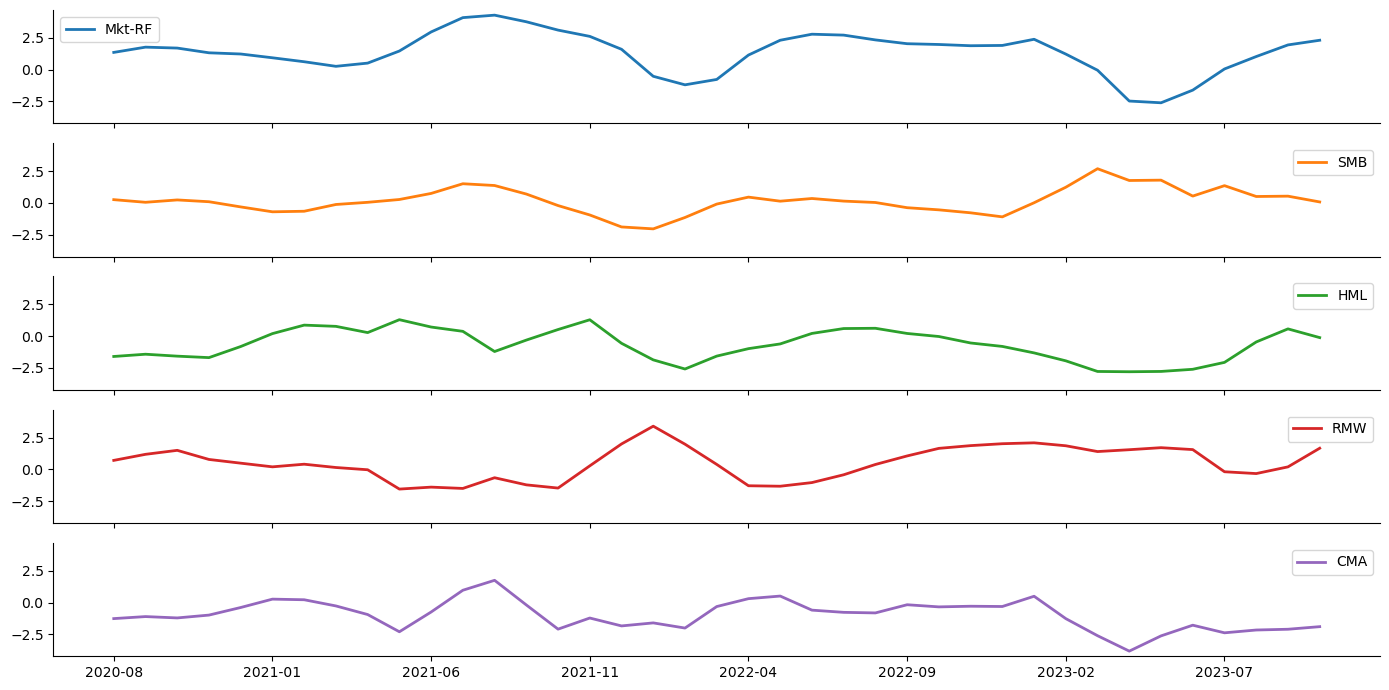

In [15]:
window = 3 # months
tkr = 'NVDA'
rolled_betas[tkr].rolling(window).mean().dropna().plot(lw=2, figsize=(14, 7), subplots=True, sharey=True)
sns.despine()
plt.tight_layout()

print(tickers)

## Short cut to Risk premia (lambdas) estimation

In [16]:
# The 2-Step FFMB regression simplified in one regression with LinearFactorModel
model = LinearFactorModel(portfolios=PF_returns, 
                          factors=ff_factor_data) #, risk_free=True
res = model.fit()
print(res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                  7   R-squared:                      0.6227
No. Factors:                          5   J-statistic:                    2.0909
No. Observations:                    43   P-value                         0.3515
Date:                  Thu, Dec 21 2023   Distribution:                  chi2(2)
Time:                          14:42:18                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         0.6524     1.0160     0.6421     0.5208     -1.3389      2.6437
SMB           -0.3995     2.6333    

In [17]:
# compare results with the above report, it yields the same result
lambdas.mean()

Mkt-RF    0.652401
SMB      -0.399504
HML      -2.860353
RMW       1.441230
CMA      -2.321468
dtype: float64

In [18]:
def FF_lambdas(BM_returns, BM_betas):
    lambdas = []
    for period in BM_returns.index:
        step2 = OLS(endog=BM_returns.loc[period, BM_betas.index],
                    exog=BM_betas
                    ).fit()
        lambdas.append(step2.params)
    lambdas = pd.DataFrame(lambdas, 
                           index=BM_returns.index,
                           columns=BM_betas.columns.tolist())
    return lambdas

In [19]:
# 2020~2023 Monthly returns
ff_factor = 'F-F_Research_Data_5_Factors_2x3'
end = dt.datetime.now()
ff_factor_data = web.DataReader(ff_factor, 'famafrench', start='2020-04', end=end)[0]
end_date = ff_factor_data.iloc[-1].name
ff_factor_data.info()

SPYG_top20 = ['AAPL','MSFT','NVDA','GOOGL','TSLA','GOOG','AMZN','XOM','LLY','UNH',
              'V','MA','CVX','MRK','ABBV','PEP','JNJ','AVGO','PG','TMO']
BM_price = yf.download(SPYG_top20, 
                       start='2020-03-01',
                       end=end_date.to_timestamp() + dt.timedelta(days=31),
                       interval='1mo', progress=False)['Adj Close']
BM_price.index = BM_price.index.to_period('M')

# convert returns into excess returns over risk-free rate used by FF Market Factor
BM_returns = BM_price.pct_change(1).dropna().loc[:end_date] * 100
BM_returns = BM_returns.sub(ff_factor_data.RF, axis=0)
BM_returns.info()
# drop risk-free rate column in FF Factors data
ff_factor_data = ff_factor_data.drop('RF', axis=1)
ff_factor_data.info()

BM_betas = FF_betas(BM_returns, ff_factor_data)
BM_lambdas = FF_lambdas(BM_returns, BM_betas)

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 43 entries, 2020-04 to 2023-10
Freq: M
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Mkt-RF  43 non-null     float64
 1   SMB     43 non-null     float64
 2   HML     43 non-null     float64
 3   RMW     43 non-null     float64
 4   CMA     43 non-null     float64
 5   RF      43 non-null     float64
dtypes: float64(6)
memory usage: 2.4 KB
<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 43 entries, 2020-04 to 2023-10
Freq: M
Data columns (total 20 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AAPL    43 non-null     float64
 1   ABBV    43 non-null     float64
 2   AMZN    43 non-null     float64
 3   AVGO    43 non-null     float64
 4   CVX     43 non-null     float64
 5   GOOG    43 non-null     float64
 6   GOOGL   43 non-null     float64
 7   JNJ     43 non-null     float64
 8   LLY     43 non-null     float64
 9   MA     

In [20]:
BM_model = LinearFactorModel(portfolios=BM_returns, 
                             factors=ff_factor_data)
BM_res = BM_model.fit()
print(BM_res)

                      LinearFactorModel Estimation Summary                      
No. Test Portfolios:                 20   R-squared:                      0.5597
No. Factors:                          5   J-statistic:                    53.884
No. Observations:                    43   P-value                         0.0000
Date:                  Thu, Dec 21 2023   Distribution:                 chi2(15)
Time:                          14:42:22                                         
Cov. Estimator:                  robust                                         
                                                                                
                            Risk Premia Estimates                             
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
Mkt-RF         2.2649     0.9198     2.4625     0.0138      0.4622      4.0676
SMB            0.9059     1.5767    

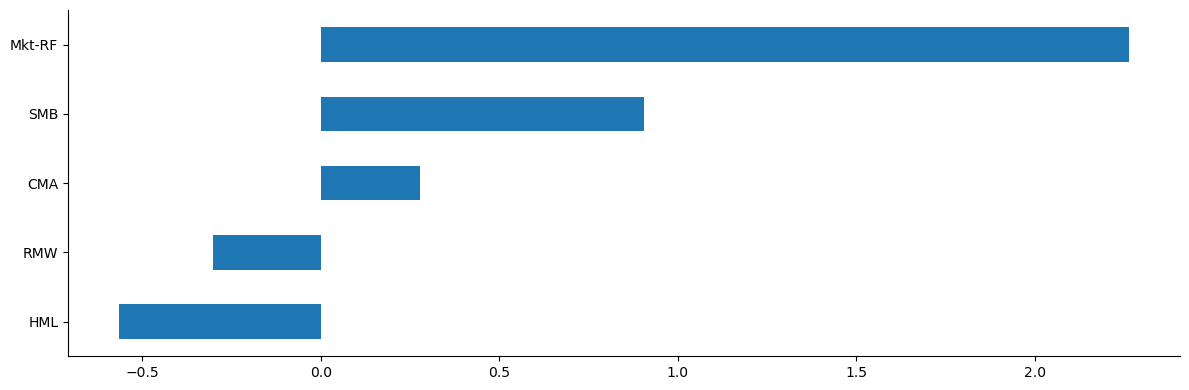

In [21]:
# Benchmark lambdas
BM_lambdas.mean().sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout();

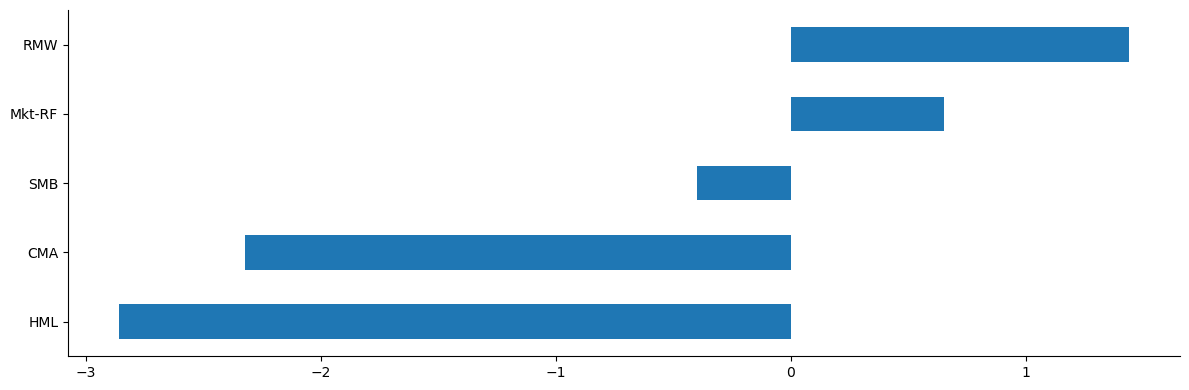

In [22]:
# Portfolio lambdas
lambdas.mean().sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout();

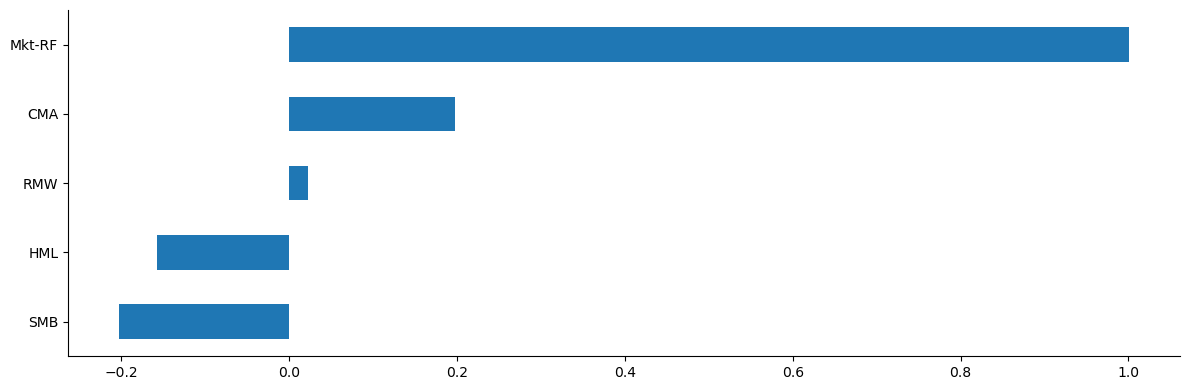

In [23]:
# Benchmark Betas, simple average over stocks
BM_betas.T.mean(axis=1).sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout();

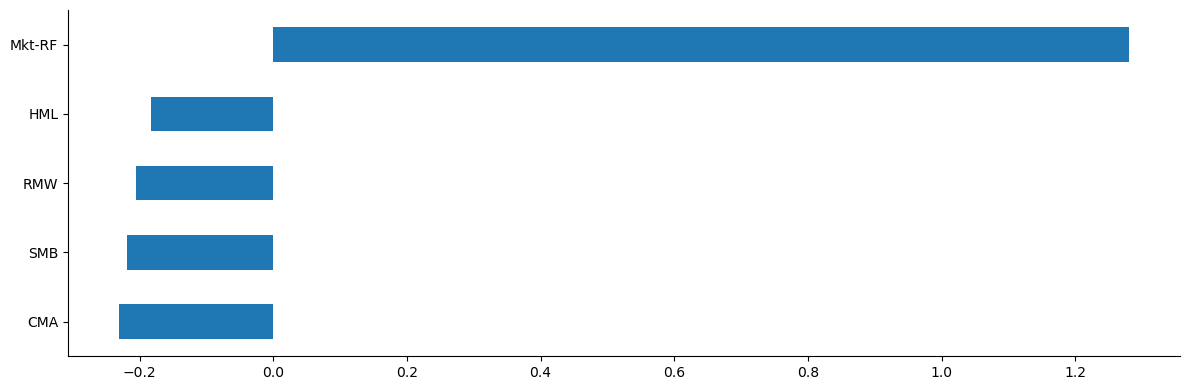

In [24]:
# Portfolio Betas, simple average over stocks
betas.T.mean(axis=1).sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout();

## Application: Return decomposition

In [28]:
# assume PF and BM are equal-weighted portfolios of its stocks holdings
ret_PF = PF_returns.mean(axis=1)
ret_BM = BM_returns.mean(axis=1)

# Active returns = Portfolio returns - Benchmark returns
# Active returns are also = factor returns + security selection returns
# where factor returns are portion of active returns attributed to PM's factor exposure tilts
# and security selection returns are portion of active returns attributed to PM's stock picking within the factors
Active_returns = ret_PF - ret_BM

# Portfolio Factor Exposure - Benchmark Factor Exposure 
# = PM's decision to take on factor exposure different from the Benchmark
# Portfolio Beta is calculated by the weighted average of stock Betas by their weights. Here, they are all equally weighted.
factor_tilts = betas.mean(axis=0) - BM_betas.mean(axis=0)

# Factor returns = sum of Factor Exposure - Benchmark Factor Exposure
# I assumed that factor tilts are multiplied by Benchmark Lambdas as factor returns only consider return deviations due to factor tilts.
# If portfolio lambdas were used, it would have included the effect of the security selection returns
factor_returns = (factor_tilts * BM_lambdas).sum(axis=1)

# security selection returns = Active returns - factor returns, residual difference
stock_selection_returns = Active_returns - factor_returns

ret_PF.index = ret_PF.index.to_timestamp()
ret_BM.index = ret_BM.index.to_timestamp()
factor_returns.index = factor_returns.index.to_timestamp()
stock_selection_returns.index = stock_selection_returns.index.to_timestamp()

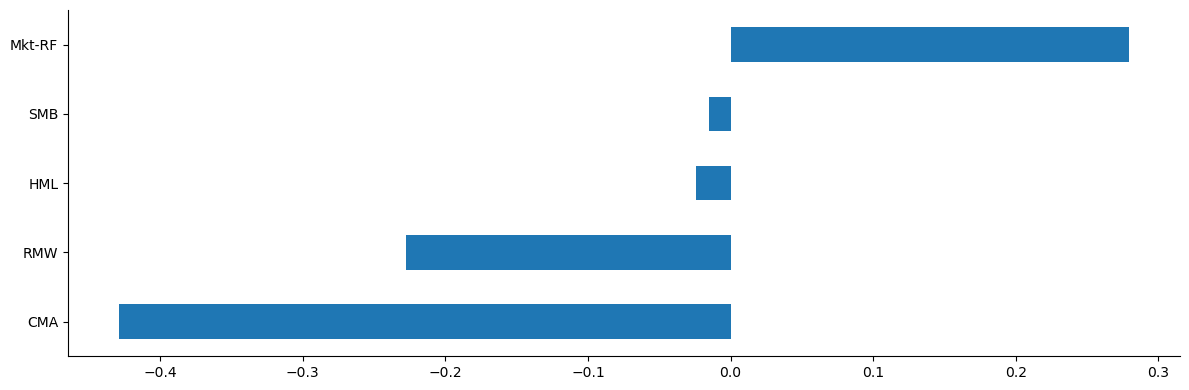

In [26]:
# factor tilts visualized
factor_tilts.sort_values().plot.barh(figsize=(12, 4))
sns.despine()
plt.tight_layout();

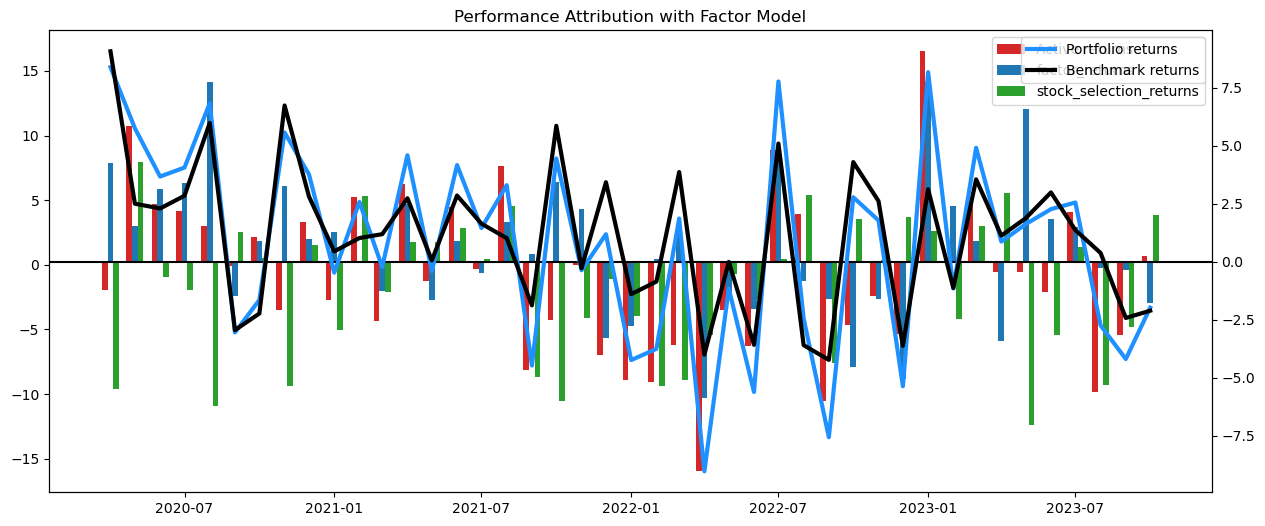

In [31]:
fig,ax = plt.subplots(figsize=(15,6))
ax1 = ax.twinx()
ax.plot(ret_PF, label='Portfolio returns', linewidth=3, color='dodgerblue')
ax.plot(ret_BM, label='Benchmark returns', linewidth=3, color='black')

Active_rets = ret_PF - ret_BM
ax1.bar(x=Active_rets.index - dt.timedelta(7), 
        height=Active_rets, label='Active returns', 
        width=7, color='tab:red')
ax1.bar(x=factor_returns.index, 
        height=factor_returns, label='factor_returns', 
        width=7, color='tab:blue')
ax1.bar(x=stock_selection_returns.index + dt.timedelta(7), 
        height=stock_selection_returns, label='stock_selection_returns', 
        width=7, color='tab:green')
plt.axhline(0,c='black')
plt.title('Performance Attribution with Factor Model')
ax.set_zorder(ax1.get_zorder()+1)
ax.patch.set_visible(False)
ax.legend();
ax1.legend();